In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import pickle
from datetime import datetime, timedelta

from imblearn.over_sampling import SMOTE
from collections import Counter

## Loading Cleaned Datasets

Our datasets were cleaned in separate Jupyter notebooks.

In [2]:
##### EPIDEMIC dataset #####
## Cases and Testing
cases_malaysia = pickle.load(open('pickle_files/cases_malaysia.pkl', 'rb'))
cases_state = pickle.load(open('pickle_files/cases_state.pkl', 'rb')) 

tests_malaysia = pickle.load(open('pickle_files/tests_malaysia.pkl', 'rb')) 
tests_state = pickle.load(open('pickle_files/tests_state.pkl', 'rb')) 

## Deaths
deaths_malaysia = pickle.load(open('pickle_files/deaths_malaysia.pkl', 'rb'))
deaths_state = pickle.load(open('pickle_files/deaths_state.pkl', 'rb')) 

## Static Data
population = pd.read_csv('dataset/static/population_moh.csv')

##### VACCINATION & REGISTRATION dataset #####
## Adverse Events Following Immunization (AEFI)
aefi = pickle.load(open('pickle_files/aefi.pkl', 'rb'))
aefi_serious = pickle.load(open('pickle_files/aefi_serious.pkl', 'rb'))

## Vaccination
vax_malaysia = pickle.load(open('pickle_files/vax_malaysia.pkl', 'rb'))
vax_state = pickle.load(open('pickle_files/vax_state.pkl', 'rb'))

## Registration
vaxreg_malaysia = pickle.load(open('pickle_files/vaxreg_malaysia.pkl', 'rb'))
vaxreg_state = pickle.load(open('pickle_files/vaxreg_state.pkl', 'rb'))

##### MYSEJAHTERA dataset #####
checkin_malaysia = pickle.load(open('pickle_files/checkin_malaysia.pkl', 'rb'))
checkin_malaysia_time = pickle.load(open('pickle_files/checkin_malaysia_time.pkl', 'rb'))
checkin_state = pickle.load(open('pickle_files/checkin_state.pkl', 'rb'))
trace_malaysia = pickle.load(open('pickle_files/trace_malaysia.pkl', 'rb'))

## Exploratory Data Analysis

#### EDA 4

What are the vaccination and registration rates per state in Malaysia?

In [3]:
ppl = population.copy()
df = vax_state.groupby('state')['daily_full'].sum()
column = df.keys()
ppl.drop(0,axis=0,inplace=True)
state = []
ratio = []
for i in column:
    ppl_num = ppl[ppl['state']==i]['pop'].sum()
    vax_num = vax_state[vax_state['state']==i]['daily_full'].sum()
    cal = vax_num/ppl_num * 100
    state.append(i)
    ratio.append(cal)
df = pd.DataFrame(data=ratio,index=state)
df.reset_index(inplace=True)
df.rename(columns={'index':'state',0:'ratio'},inplace=True)
           

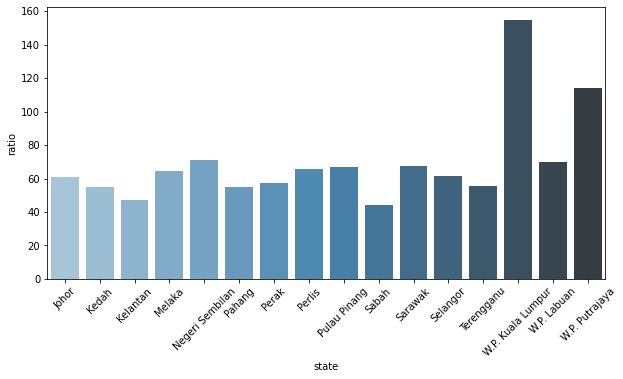

In [4]:
plt.figure(figsize=(10, 5))
sns.barplot(x='state', y='ratio', data=df, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

In [5]:
# interactive plot
#fig = px.bar(df,x='state',y='ratio')
#fig.show()  

In [6]:
df = vaxreg_state.groupby('state')['total'].sum()
column = df.keys()
state = []
ratio = []
for i in column:
    ppl_num = ppl[ppl['state']==i]['pop'].sum()
    vax_num = vaxreg_state[vaxreg_state['state']==i]['total'].sum()
    cal = vax_num/ppl_num * 100
    state.append(i)
    ratio.append(cal)
df = pd.DataFrame(data=ratio,index=state)
df.reset_index(inplace=True)
df.rename(columns={'index':'state',0:'ratio'},inplace=True)

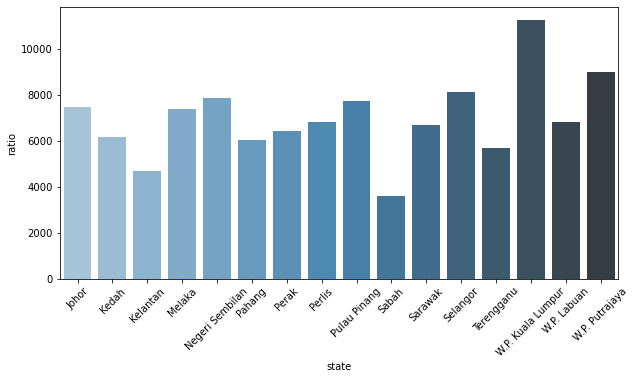

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(x='state', y='ratio', data=df, palette='Blues_d')
plt.xticks(rotation=45)
plt.show()

In [8]:
# interactive plot
#fig = px.bar(df,x='state',y='ratio')
#fig.show()    

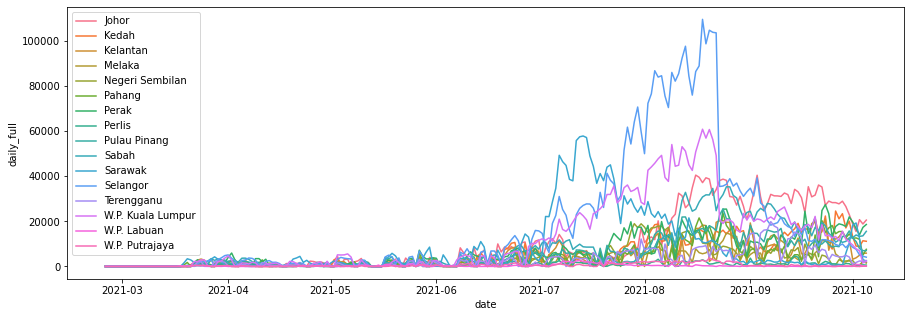

In [9]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=vax_state, x='date', y='daily_full', hue='state')
plt.legend()
plt.show()

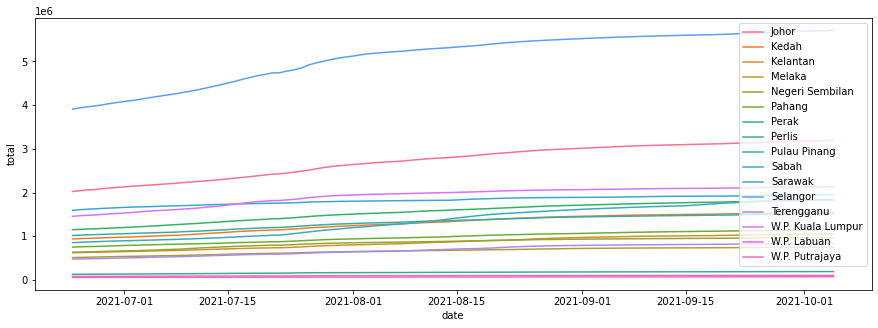

In [10]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=vaxreg_state, x='date', y='total', hue='state')
plt.legend()
plt.show()

In [11]:
# interactive plot (using plotly)
#fig1 = px.line(vax_state, x="date", y="daily_full", color='state')
#fig1.show()
#fig2 = px.line(vaxreg_state, x="date", y="total", color='state')
#fig2.show()

#### EDA 5

What the types and total number of side effects of each type of vaccine ?

In [12]:
df = vax_malaysia[['pfizer1', 'pfizer2','sinovac1', 'sinovac2', 'astra1', 'astra2', 'cansino']].sum()
df = pd.DataFrame(df)
df.reset_index(inplace=True)
df = df.rename(columns={'index':'dose',0:'total'})
df['vaxtype'] = ['pfizer','pfizer','sinovac','sinovac','astra','astra','cansino']

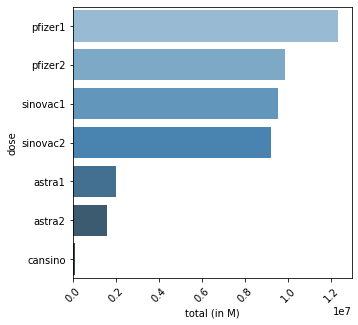

In [13]:
plt.figure(figsize=(5, 5))
sns.barplot(x='total', y='dose', data=df, palette='Blues_d')
plt.xticks(rotation=45)
plt.xlabel('total (in M)')
plt.show()

In [14]:
# interactive plot (using plotly)
#fig1 = px.bar(df,x='total',y='dose')
#fig1.show()

In [15]:
df = aefi[['vaxtype','d1_site_pain','d1_site_swelling','d1_site_redness','d1_tiredness','d1_headache','d1_muscle_pain','d1_joint_pain','d1_weakness', 'd1_fever','d1_vomiting','d1_chills','d1_rash','d2_site_pain','d2_site_swelling','d2_site_redness','d2_tiredness','d2_headache','d2_muscle_pain','d2_joint_pain','d2_weakness', 'd2_fever','d2_vomiting','d2_chills','d2_rash']].copy()
df = df.groupby('vaxtype').sum()
df2 = aefi_serious.groupby('vaxtype').sum()


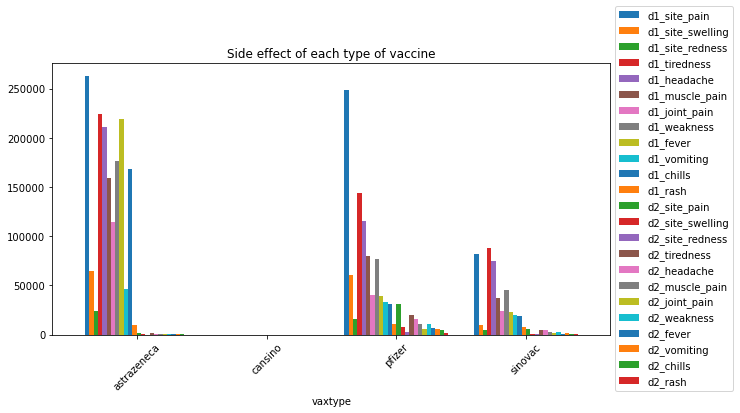

In [16]:
df.plot.bar(figsize=(10, 5), width=0.8)
plt.title('Side effect of each type of vaccine')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.show()

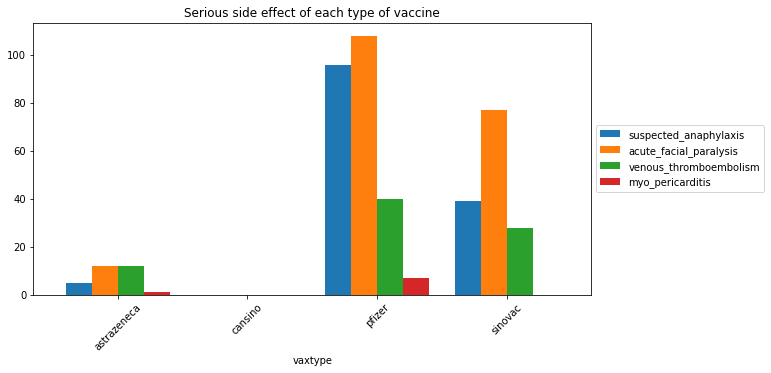

In [17]:
df2.plot.bar(figsize=(10, 5), width=0.8)
plt.title('Serious side effect of each type of vaccine')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.show()

In [18]:
# interactive plot (using plotly)
#fig1 = px.bar(df,barmode='group',title = 'side effect of each type of vaccine')
#fig2 = px.bar(df2,barmode='group',title = 'serious side effect of each type of vaccine')
#fig1.show()
#fig2.show()

#### EDA 6

Which type of vaccine is given to more people?

In [19]:
df

,d1_site_pain,d1_site_swelling,d1_site_redness,d1_tiredness,d1_headache,d1_muscle_pain,d1_joint_pain,d1_weakness,d1_fever,d1_vomiting,...,d2_site_redness,d2_tiredness,d2_headache,d2_muscle_pain,d2_joint_pain,d2_weakness,d2_fever,d2_vomiting,d2_chills,d2_rash
vaxtype,,,,,,,,,,,,,,,,,,,,,
astrazeneca,262941,64947,23704,224269,210573,159350,114575,176252,218685,46574,...,122,1318,1173,673,407,759,529,297,445,56
cansino,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pfizer,248145,60653,15879,143623,115331,79838,40099,76394,39511,32859,...,2393,19730,16124,11286,6053,11221,6409,5506,5232,1697
sinovac,81887,9631,4758,88212,74537,37701,23959,45551,23099,20210,...,481,5117,4639,2350,1502,2778,1138,1377,954,475


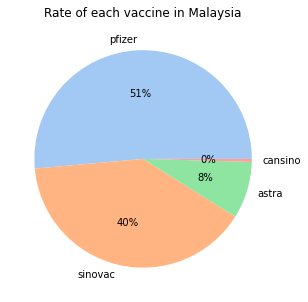

In [20]:
df = vax_malaysia[['pfizer1','sinovac1','astra1','cansino']]
df = df.rename(columns={'pfizer1':'pfizer','sinovac1':'sinovac','astra1':'astra'})
df = df.sum()
df = pd.DataFrame(df)
df = df.reset_index()
df = df.rename(columns={'index':'vaxtype',0:'total'})

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(5, 5))
plt.pie(df['total'], labels=df['vaxtype'], colors=colors, autopct='%.0f%%')
plt.title('Rate of each vaccine in Malaysia')
plt.show()

In [21]:
# interactive plot (using plotly)
#fig = px.pie(df, values='total', names='vaxtype',title='Rate of each vaccine in Malaysia',color_discrete_sequence=px.colors.sequential.RdBu)
#fig.show()

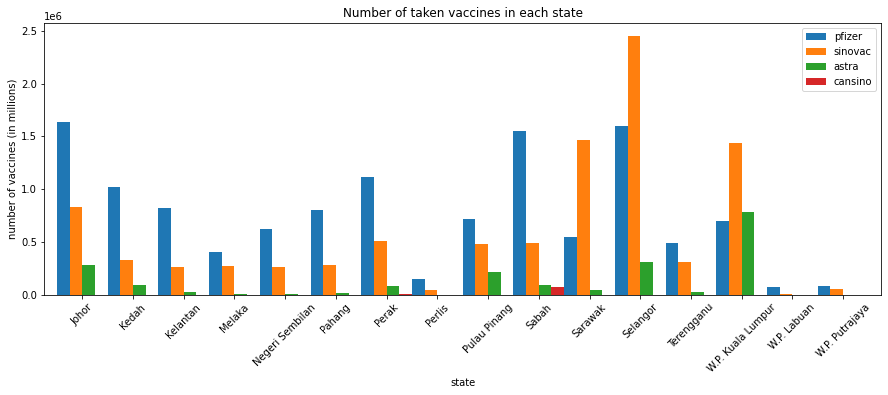

In [22]:
df = vax_state[['state','pfizer1','sinovac1','astra1','cansino']]
df = df.rename(columns={'pfizer1':'pfizer','sinovac1':'sinovac','astra1':'astra'})
df = df.groupby('state').sum()

df.plot.bar(figsize=(15, 5), width=1)
plt.title('Number of taken vaccines in each state')
plt.xticks(rotation=45)
plt.ylabel('number of vaccines (in millions)')
plt.show()

In [23]:
# interactive plot (using plotly)
#fig = px.bar(df,barmode='group',title = 'Vaccine in each state')
#fig.show()

Extra EDA?

#### EDA 7

Which states are recovering? More vaccinated person and less cases. Compare real world events (which state is in which phase)?

In [24]:

def plot_cases_vax(state):
    # get vaccination status of state
    vax = vax_state[vax_state['state'] == state].copy()
    vax['cumul_cansino'] = vax['cansino'].cumsum()
    vax['cumul_total_vax'] = vax['cumul_full'] + vax['cumul_cansino'] + vax['cumul_full_child'] 
    vax = vax[['date', 'daily', 'cumul_total_vax']].copy()
    vax['date'] = vax['date'].astype('datetime64[ns]')

    # get covid cases of state
    case = cases_state[cases_state['state'] == state][['date', 'cases_new']].copy()
    case['date'] = case['date'].astype('datetime64[ns]')

    # merging both dataframes
    vax_status = pd.merge(vax, case, on='date', how='inner', indicator=True)
    vax_status.drop(['_merge'], axis=1, inplace=True)

    # working on vaccination status
    pop = population.loc[population['state'] == state, 'pop'].values[0]
    
    vax_status['cumul_total_vax_norm'] = vax_status['cumul_total_vax']/pop
    vax_status['cases_new_norm']=(vax_status['cases_new']-vax_status['cases_new'].min())/(vax_status['cases_new'].max()-vax_status['cases_new'].min())
    vax_status['cases_new_ma'] = vax_status['cases_new_norm'].rolling(window=7).mean()
    
    vax_status = vax_status.dropna()
    
    plt.figure(figsize = (20,5))

    plt.plot(vax_status['date'], vax_status['cases_new_norm'], color='pink', label='Daily Confirmed New Cases', linestyle='--') 
    plt.plot(vax_status['date'], vax_status['cases_new_ma'], color='red', label='Daily Confirmed New Cases (7-day Moving Average)') 
    plt.plot(vax_status['date'], vax_status['cumul_total_vax_norm'], color='blue', label='Normalized Cummulative Number of Vaccinated Person') 
    plt.plot(vax_status['date'], pd.Series([1 for i in range(218)]), color='lightgreen', label='Population', linestyle='--') 
    
    
    x = vax_status['date']
    y = vax_status['cases_new_ma']
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "{:%Y-%m-%d}".format(xmax)

    plt.annotate(text, xy=(xmax+timedelta(days=6), ymax), xytext=(xmax, ymax+0.15),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    # labeling the % of vaccinated people
    y_2 = vax_status['cumul_total_vax_norm']    
    y_val = y_2[np.argmax(y)]
    text_2= "{:.2f}%".format(y_val*100)

    plt.annotate(text_2, xy=(xmax+timedelta(days=6), y_val+0.05), xytext=(xmax++timedelta(days=4), y_val-0.15),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    
    plt.title(state)
    plt.legend()


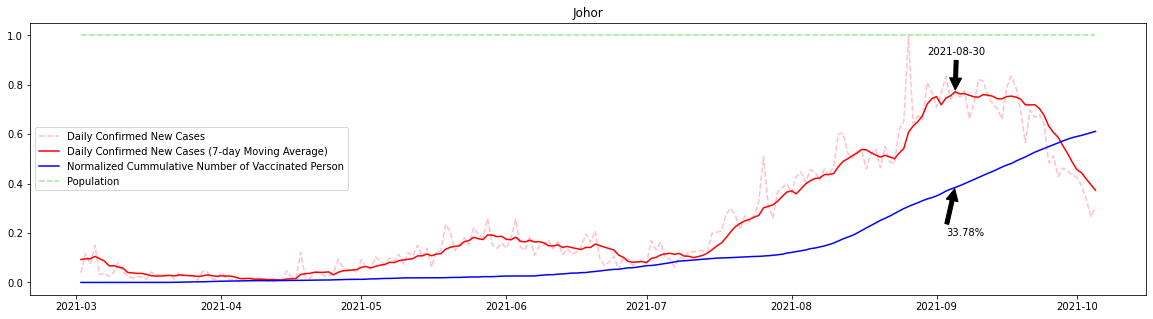

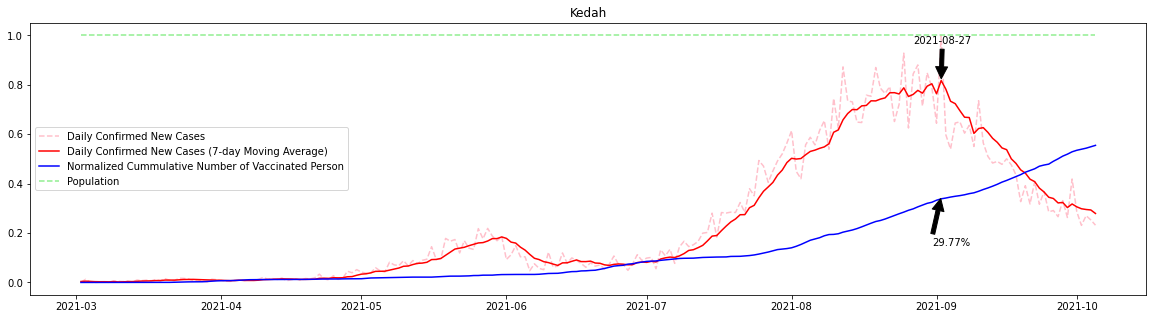

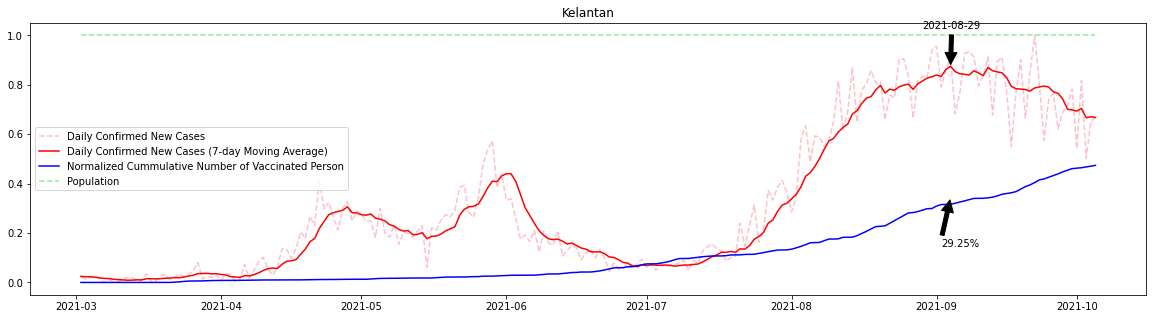

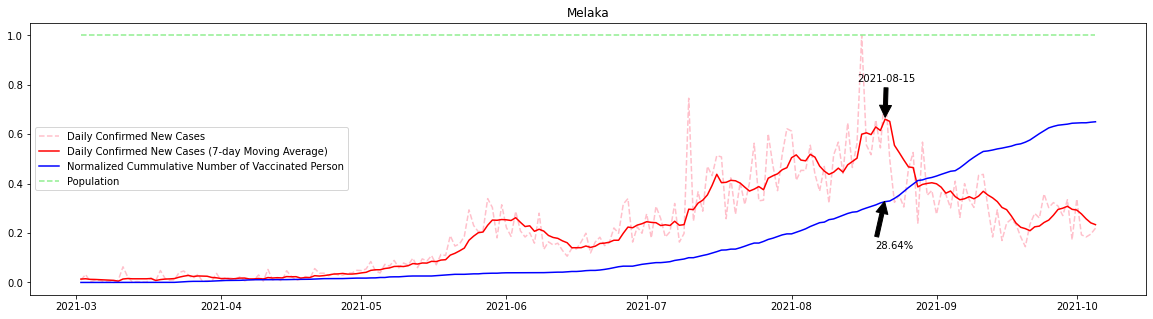

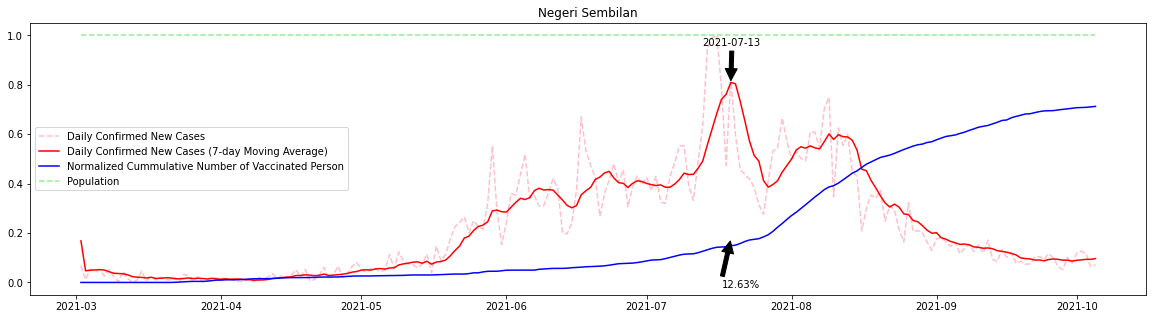

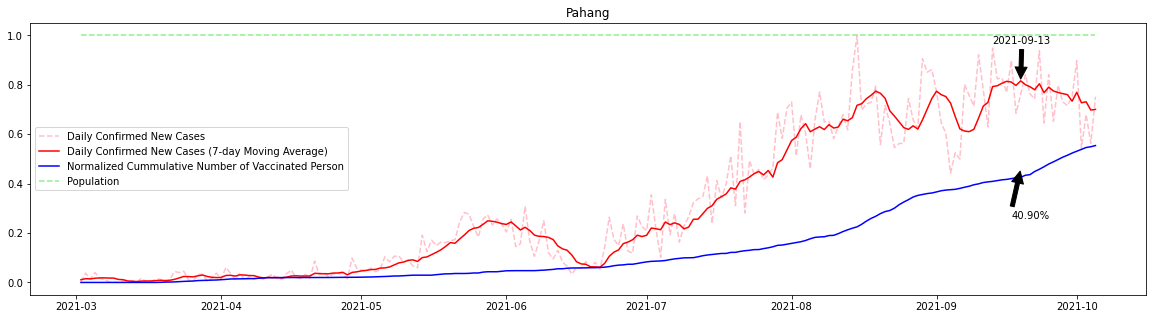

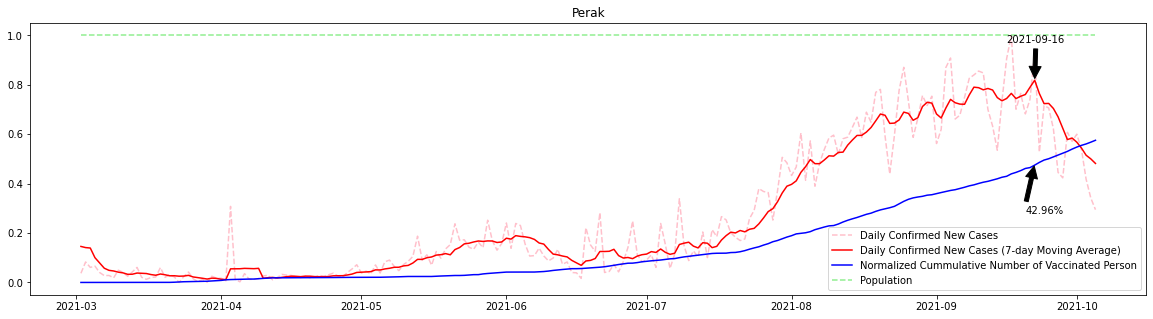

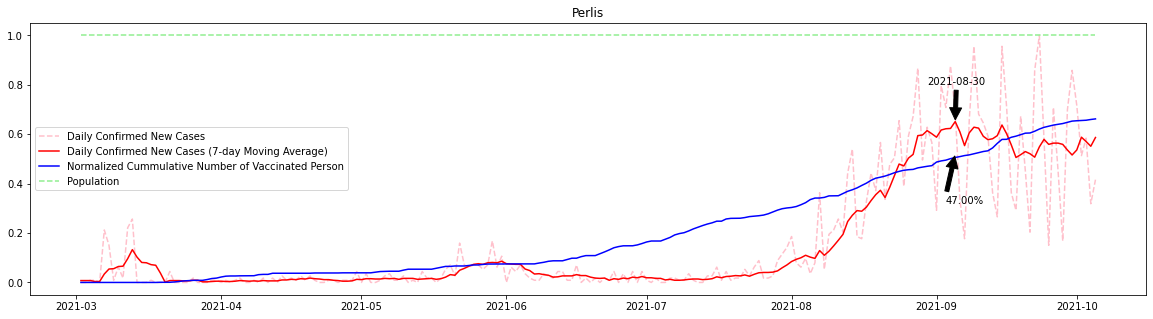

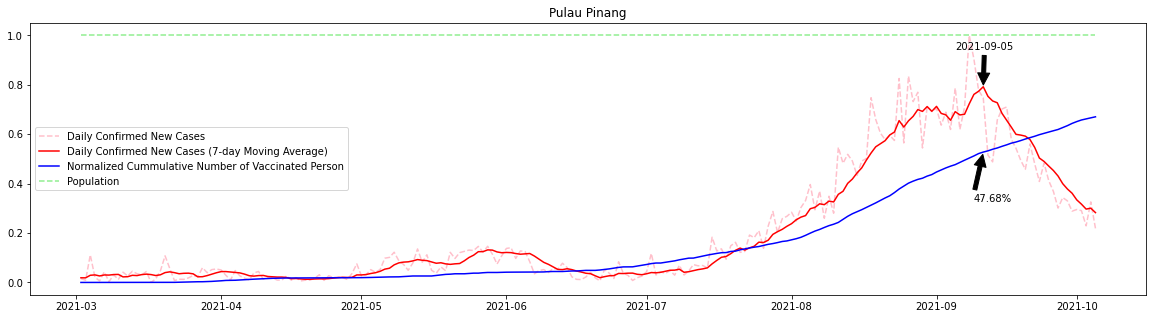

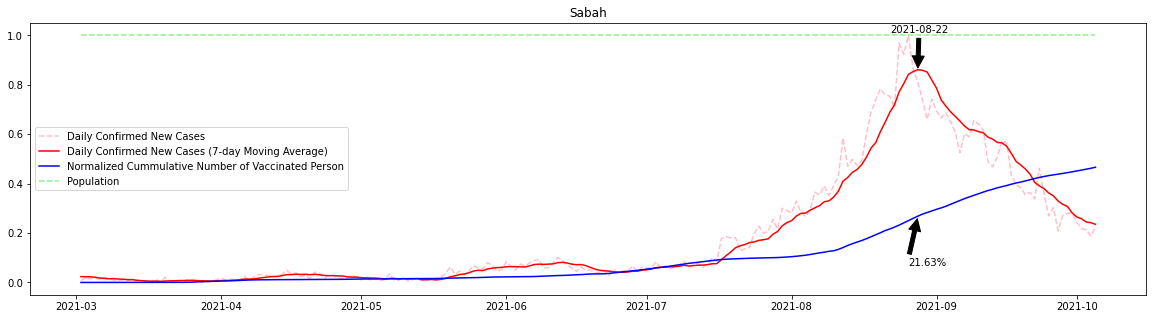

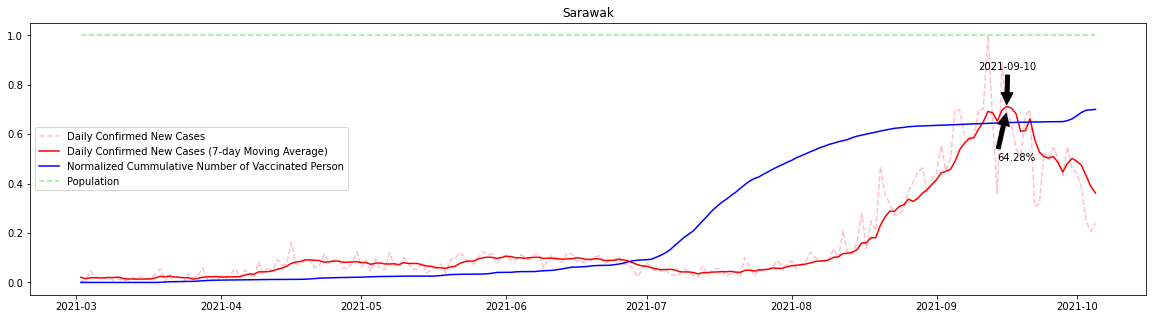

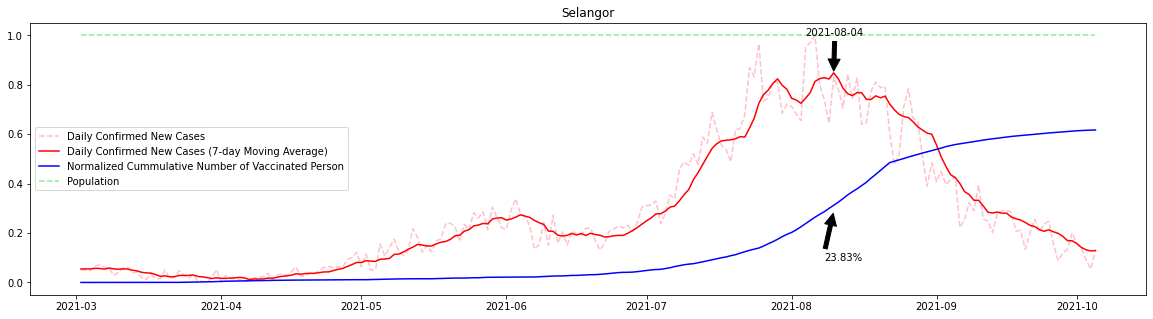

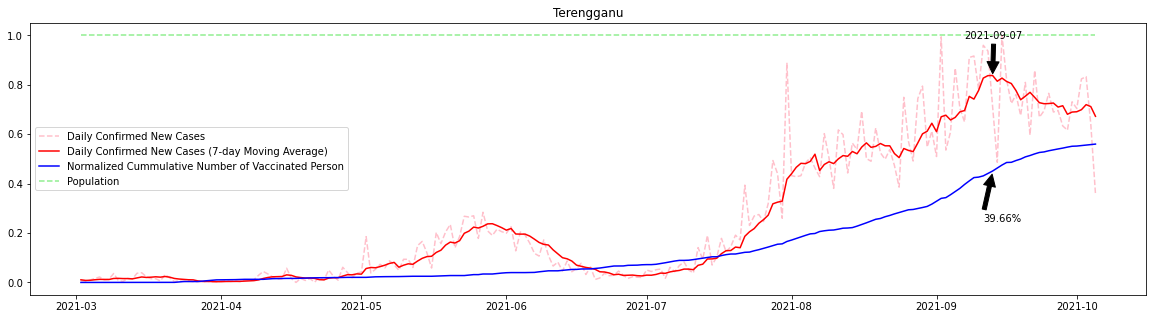

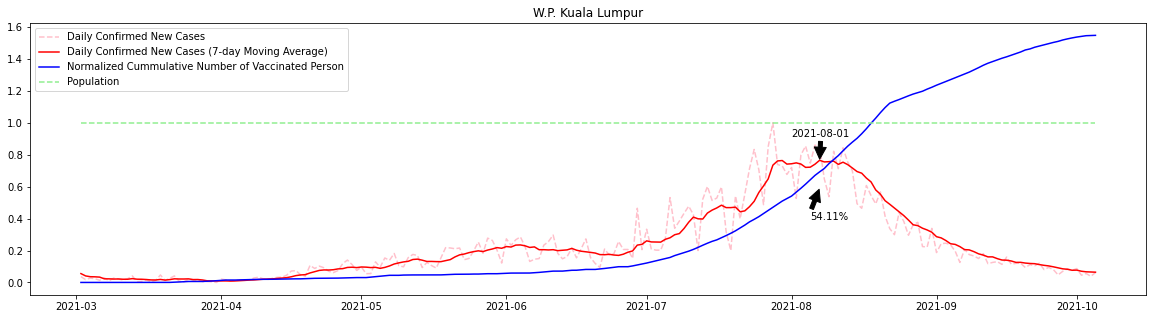

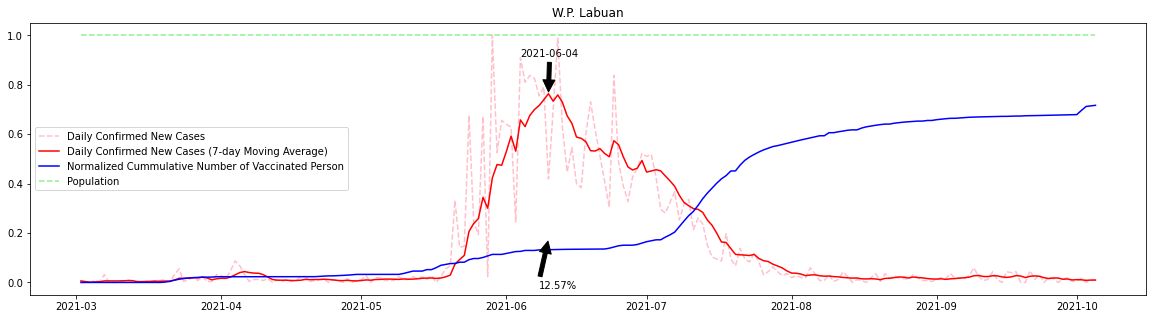

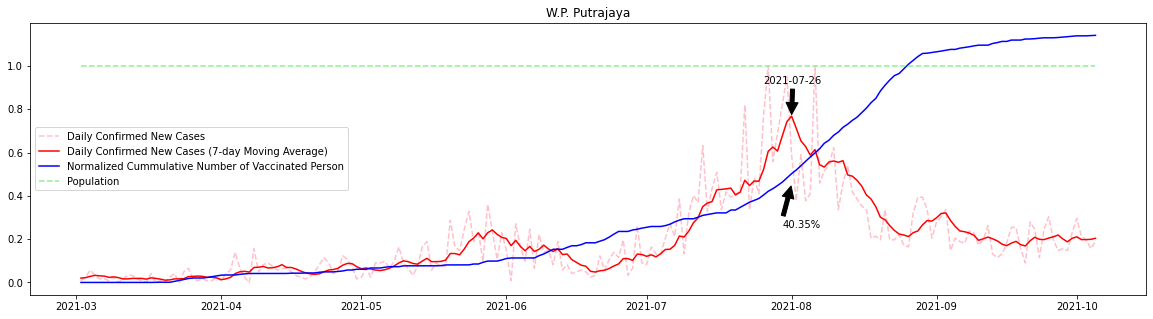

In [25]:
states = vax_state['state'].unique()

for state in states:
    plot_cases_vax(state)

#### EDA 8
When is the time of the day with most checkins?

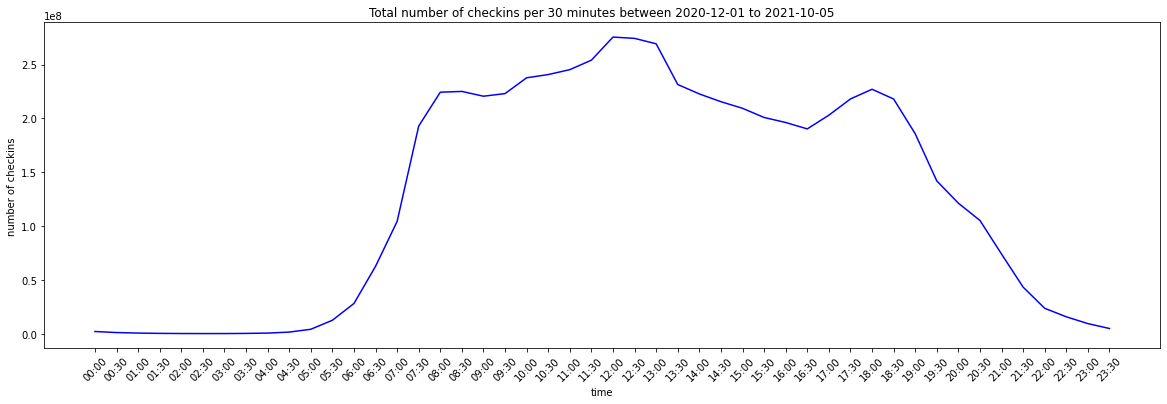

In [26]:
checkin_time = pd.DataFrame(checkin_malaysia_time[[str(x) for x in range(48)]].sum())
time = []
for x in range(24):
    time.extend([f'{x:02d}:00', f'{x:02d}:30'])
checkin_time.insert(0, 'time', time, True)
checkin_time.rename(columns={0: 'checkins'}, inplace=True)

plt.figure(figsize = (20,6))
plt.plot(checkin_time['time'], checkin_time['checkins'], color='blue')
plt.title('Total number of checkins per 30 minutes between 2020-12-01 to 2021-10-05')
plt.xlabel('time')
plt.ylabel('number of checkins')
plt.xticks(rotation=45)
plt.show()

In [27]:
# interactive plot (using plotly)
#fig = px.line(checkin_time, x='time', y='total number of checkins')
#fig.update_xaxes(tickangle=270) # rotate 270
#fig.update_layout(title='Total number of checkins per 30 minutes between 2020-12-01 to 2021-10-05')
#fig.show()

The graph above is plotted by summing the total number of MySejahtera checkins in every 30 minutes of a day. The data from `2020-12-01` to `2021-10-05`, spanning over 309 days.

From the chart above, we can roughly observe 3 peaks, which are around **8am**, **12pm**, and **6pm** respectively. Presumeably these are the preferred hours for Malaysians to buy their meals. 


#### EDA 9

What are the dates with the highest number of checkins? How does it correlates with the number of cases and deaths during the day?

In [32]:
cases_malaysia['date'] = cases_malaysia['date'].astype('datetime64[ns]')
tests_malaysia['date'] = tests_malaysia['date'].astype('datetime64[ns]')
deaths_malaysia['date'] = deaths_malaysia['date'].astype('datetime64[ns]')

In [33]:
# merge cases_state and tests_state together
df_cases_tests = (pd.merge(cases_malaysia, tests_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests.drop(['_merge'], axis=1, inplace=True)

# merge deaths_sta
df_cases_tests_deaths = (pd.merge(df_cases_tests, deaths_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests_deaths.drop(['_merge'], axis=1, inplace=True)

# merge checkins
df_all = (pd.merge(df_cases_tests_deaths, checkin_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_all.drop(['_merge'], axis=1, inplace=True)

# reset index
df_all.reset_index(inplace = True)

In [34]:
def minmaxnorm(col):
    return ( (col-col.min()) / (col.max()-col.min()) )

df_9 = df_all[['date', 'cases_new', 'deaths_new', 'rtk-ag', 'pcr', 'checkins']].copy() # df for eda 9
df_9['cases_norm'] = minmaxnorm(df_9['cases_new'])
df_9['deaths_norm'] = minmaxnorm(df_9['deaths_new'])

df_9['tests_new'] = df_9['rtk-ag'] + df_9['pcr']
df_9['tests_norm'] = minmaxnorm(df_9['tests_new'])
df_9['checkins_norm'] = minmaxnorm(df_9['checkins'])
df_9

,date,cases_new,deaths_new,rtk-ag,pcr,checkins,cases_norm,deaths_norm,tests_new,tests_norm,checkins_norm
0,2020-12-01,1472,2,7347,16024,17492265,0.026150,0.003378,23371,0.000000,0.523505
1,2020-12-02,851,2,8761,15962,17695726,0.000000,0.003378,24723,0.008564,0.530854
2,2020-12-03,1075,11,10533,21196,17063123,0.009432,0.018581,31729,0.052943,0.508004
3,2020-12-04,1141,0,11457,19657,18350879,0.012212,0.000000,31114,0.049048,0.554519
4,2020-12-05,1123,4,8749,16905,19711082,0.011454,0.006757,25654,0.014462,0.603651
...,...,...,...,...,...,...,...,...,...,...,...
301,2021-09-28,11332,240,105105,47090,26541913,0.441342,0.405405,152195,0.816029,0.850387
302,2021-09-29,12434,208,99474,46182,26994270,0.487746,0.351351,145656,0.774608,0.866727
303,2021-09-30,12735,192,96673,43082,27815729,0.500421,0.324324,139755,0.737228,0.896399
304,2021-10-01,11889,121,100825,37382,28980407,0.464797,0.204392,138207,0.727422,0.938468


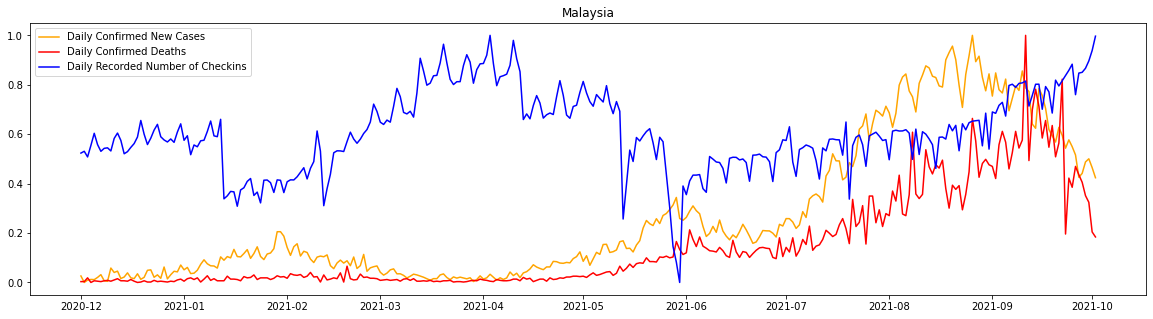

In [35]:
plt.figure(figsize = (20,5))

plt.plot(df_9['date'], df_9['cases_norm'], color='orange', label='Daily Confirmed New Cases') 
plt.plot(df_9['date'], df_9['deaths_norm'], color='red', label='Daily Confirmed Deaths') 
plt.plot(df_9['date'], df_9['checkins_norm'], color='blue', label='Daily Recorded Number of Checkins') 

plt.title('Malaysia')
plt.legend()

In [36]:
# interactive plot
#fig = px.line(df_9, x='date', y=['cases_norm', 'deaths_norm', 'checkins_norm'])
#fig.show()

The day with the highest number of checkins is the **3rd of April 2021**. The number of cases and deaths are considered as low.